In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install --quiet xgboost lightgbm google-api-python-client pytube seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import random
from urllib.parse import urlparse, parse_qs

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Replace this path with your CSV path on Kaggle
data_path = '/kaggle/input/the-movie-repository-db/data4.csv'
df = pd.read_csv(data_path).dropna()

label_mapping = {
    'Disaster': 0, 'Flop': 1, 'Successful': 2, 'Average': 3,
    'Hit': 4, 'Outstanding': 5, 'Superhit': 6, 'Blockbuster': 7
}

In [4]:
def extract_youtube_id(url):
    if 'youtube.com/watch' in url:
        return parse_qs(urlparse(url).query).get('v', [None])[0]
    elif 'youtu.be' in url:
        return url.split('/')[-1].split('?')[0]
    elif re.match(r'^[A-Za-z0-9_-]{11}$', url):
        return url
    return None

df['youtube_id'] = df['Trailer'].apply(extract_youtube_id)

In [5]:
def get_video_statistics(video_id):
    # replace with real YouTube Data API call if you have a key
    return {
      'views': random.randint(1e5,1e7),
      'likes': random.randint(5e3,5e5),
      'comments': random.randint(1e3,5e4),
      'duration': f"PT{random.randint(1,4)}M{random.randint(0,59)}S"
    }

def iso_duration_to_seconds(dur):
    h=m=s=0
    m_split = dur.split('H')
    if len(m_split)>1:
        h = int(m_split[0].replace('PT',''))
        dur = m_split[1]
    dur = dur.replace('PT','')
    if 'M' in dur:
        m, dur = dur.split('M')
        m = int(m)
    if 'S' in dur:
        s = int(dur.replace('S',''))
    return h*3600 + m*60 + s

stats = []
for vid in df['youtube_id']:
    if vid:
        st = get_video_statistics(vid)
        st['duration_sec'] = iso_duration_to_seconds(st['duration'])
        st['youtube_id'] = vid
        st['engagement_ratio'] = st['likes']/st['views']*1000
        stats.append(st)
stats_df = pd.DataFrame(stats)

In [6]:
def extract_video_features(vid):
    return {
      'youtube_id': vid,
      'brightness': random.uniform(0.3,0.7),
      'color_variance': random.uniform(0.1,0.5),
      'scene_changes': random.randint(20,100),
      'audio_volume': random.uniform(0.4,0.9),
      'music_speech_ratio': random.uniform(0.2,0.8),
      'editing_pace': random.uniform(1.0,5.0),
      'fast_cuts_ratio': random.uniform(0.1,0.6)
    }

vid_feats = []
for vid in df['youtube_id']:
    if vid:
        f = extract_video_features(vid)
        vid_feats.append(f)
vid_feat_df = pd.DataFrame(vid_feats)

In [7]:
data = df.merge(stats_df, on='youtube_id', how='left') \
         .merge(vid_feat_df, on='youtube_id', how='left') \
         .dropna(subset=['views','likes','comments'])
data['y'] = data['Verdict'].map(label_mapping)

In [8]:
numeric = ['Year','Duration','views','likes','comments',
           'duration_sec','engagement_ratio',
           'brightness','color_variance','scene_changes',
           'audio_volume','music_speech_ratio','editing_pace','fast_cuts_ratio']
categorical = ['Rate','Genre1','Genre2','Genre3','Language']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical)
])

In [9]:
models = [
  ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced')),
  ('SVM',    SVC(class_weight='balanced')),
  ('DT',     DecisionTreeClassifier(class_weight='balanced')),
  ('RF',     RandomForestClassifier(class_weight='balanced', n_estimators=100)),
  ('XGB',    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
  ('LGBM',   LGBMClassifier(class_weight='balanced'))
]


=== Split 80-20 ===

LogReg:


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


acc: 0.5008460236886633
f1: 0.5651685469322422
prec: 0.6769151495931625
rec: 0.5008460236886633
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       393
           1       0.19      0.23      0.21        66
           2       0.09      0.12      0.10        42
           3       0.07      0.13      0.09        23
           4       0.02      0.05      0.03        20
           5       0.26      0.23      0.24        31
           6       0.14      0.57      0.22         7
           7       0.21      0.78      0.33         9

    accuracy                           0.50       591
   macro avg       0.24      0.34      0.25       591
weighted avg       0.68      0.50      0.57       591



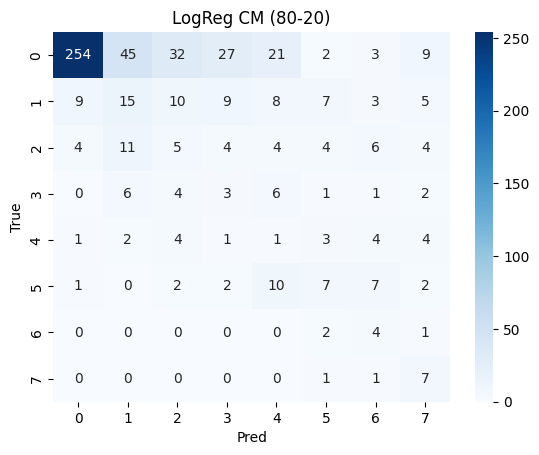


SVM:
acc: 0.4500846023688663
f1: 0.5234549159655748
prec: 0.67745525361137
rec: 0.4500846023688663
              precision    recall  f1-score   support

           0       0.95      0.56      0.71       393
           1       0.17      0.38      0.24        66
           2       0.07      0.17      0.10        42
           3       0.06      0.09      0.07        23
           4       0.03      0.05      0.04        20
           5       0.21      0.29      0.24        31
           6       0.25      0.14      0.18         7
           7       0.17      0.11      0.13         9

    accuracy                           0.45       591
   macro avg       0.24      0.22      0.21       591
weighted avg       0.68      0.45      0.52       591



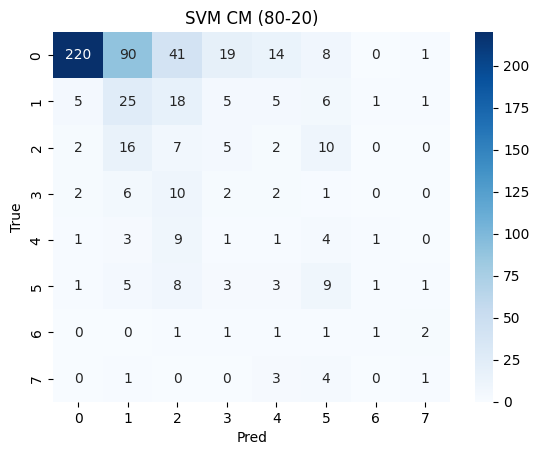


DT:
acc: 0.5397631133671743
f1: 0.5510727001936045
prec: 0.564792574337009
rec: 0.5397631133671743
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       393
           1       0.23      0.30      0.26        66
           2       0.09      0.10      0.09        42
           3       0.00      0.00      0.00        23
           4       0.04      0.05      0.05        20
           5       0.15      0.13      0.14        31
           6       0.00      0.00      0.00         7
           7       0.11      0.11      0.11         9

    accuracy                           0.54       591
   macro avg       0.18      0.18      0.18       591
weighted avg       0.56      0.54      0.55       591



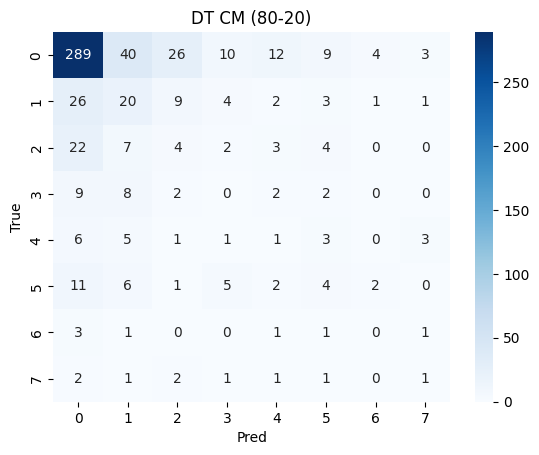


RF:
acc: 0.6683587140439933
f1: 0.5424420667212676
prec: 0.4695984984271546
rec: 0.6683587140439933
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       393
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        20
           5       0.43      0.10      0.16        31
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         9

    accuracy                           0.67       591
   macro avg       0.14      0.14      0.12       591
weighted avg       0.47      0.67      0.54       591



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


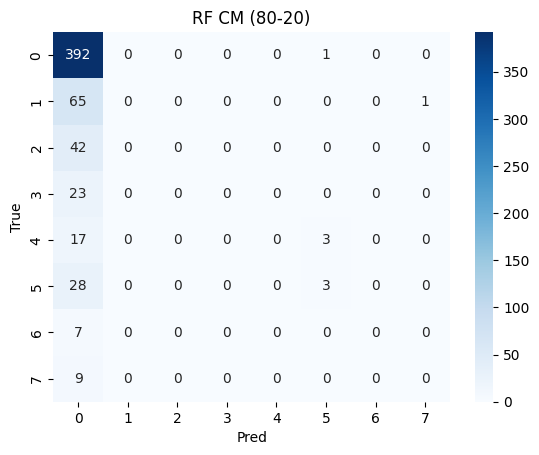


XGB:
acc: 0.688663282571912
f1: 0.6204537309745678
prec: 0.6049453757527387
rec: 0.688663282571912
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       393
           1       0.30      0.14      0.19        66
           2       0.29      0.12      0.17        42
           3       0.00      0.00      0.00        23
           4       0.50      0.05      0.09        20
           5       0.27      0.23      0.25        31
           6       1.00      0.14      0.25         7
           7       0.50      0.22      0.31         9

    accuracy                           0.69       591
   macro avg       0.45      0.23      0.26       591
weighted avg       0.60      0.69      0.62       591



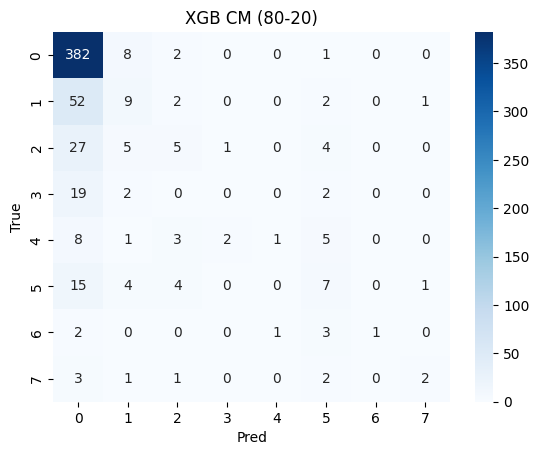


LGBM:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3103
[LightGBM] [Info] Number of data points in the train set: 2363, number of used features: 70
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

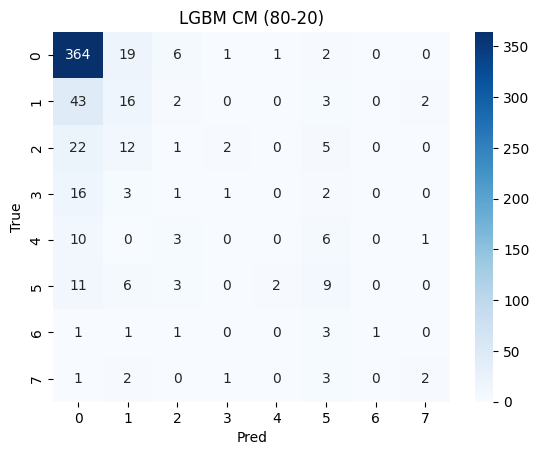


=== Split 75-25 ===

LogReg:


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


acc: 0.4844384303112314
f1: 0.5540431821954165
prec: 0.6679468116391762
rec: 0.4844384303112314
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       491
           1       0.18      0.22      0.20        82
           2       0.07      0.09      0.08        53
           3       0.05      0.10      0.07        29
           4       0.01      0.04      0.02        24
           5       0.18      0.18      0.18        39
           6       0.09      0.33      0.14         9
           7       0.17      0.50      0.25        12

    accuracy                           0.48       739
   macro avg       0.21      0.26      0.21       739
weighted avg       0.67      0.48      0.55       739



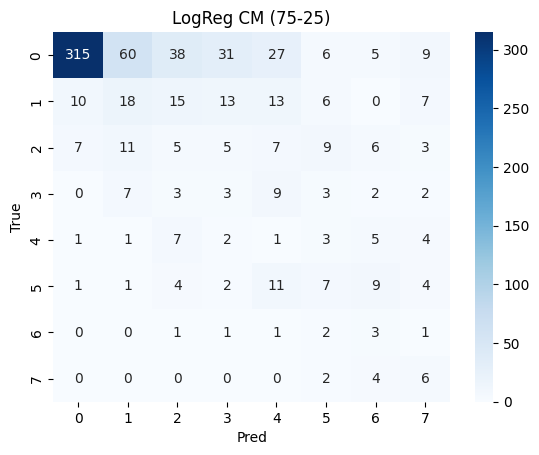


SVM:
acc: 0.4749661705006766
f1: 0.5394865571595906
prec: 0.6725064808894309
rec: 0.4749661705006766
              precision    recall  f1-score   support

           0       0.93      0.58      0.71       491
           1       0.18      0.37      0.24        82
           2       0.13      0.26      0.18        53
           3       0.12      0.21      0.15        29
           4       0.05      0.08      0.06        24
           5       0.23      0.33      0.27        39
           6       0.20      0.11      0.14         9
           7       0.10      0.08      0.09        12

    accuracy                           0.47       739
   macro avg       0.24      0.25      0.23       739
weighted avg       0.67      0.47      0.54       739



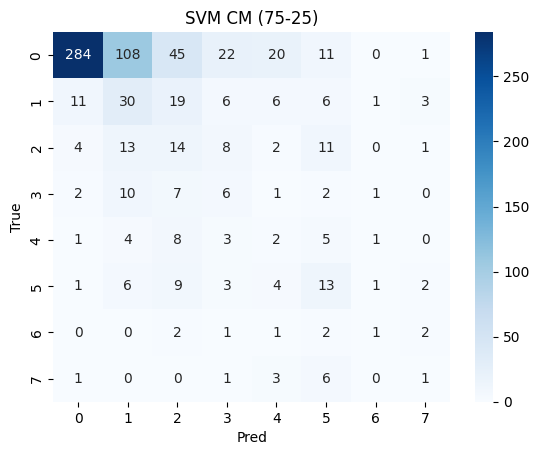


DT:
acc: 0.5250338294993234
f1: 0.5337747213129338
prec: 0.5452930620442329
rec: 0.5250338294993234
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       491
           1       0.12      0.16      0.14        82
           2       0.07      0.06      0.06        53
           3       0.04      0.03      0.04        29
           4       0.03      0.04      0.04        24
           5       0.06      0.05      0.06        39
           6       0.00      0.00      0.00         9
           7       0.25      0.50      0.33        12

    accuracy                           0.53       739
   macro avg       0.17      0.20      0.18       739
weighted avg       0.55      0.53      0.53       739



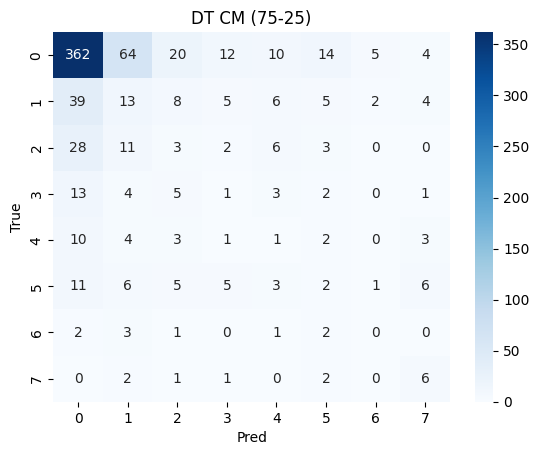


RF:
acc: 0.6725304465493911
f1: 0.5505596227699052
prec: 0.5791404690525497
rec: 0.6725304465493911
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       491
           1       1.00      0.02      0.05        82
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        24
           5       0.33      0.10      0.16        39
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        12

    accuracy                           0.67       739
   macro avg       0.25      0.14      0.13       739
weighted avg       0.58      0.67      0.55       739



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


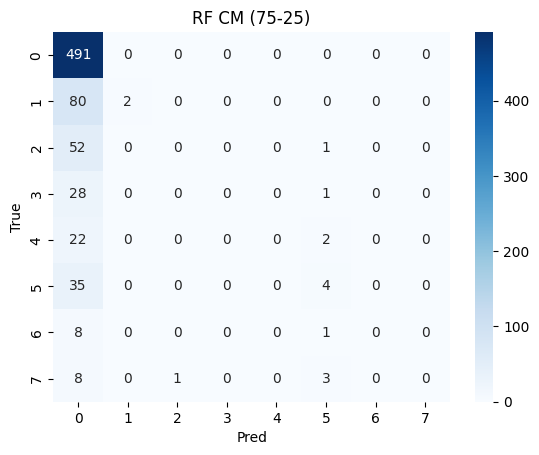


XGB:
acc: 0.6779431664411367
f1: 0.6063348569773174
prec: 0.5797890165287944
rec: 0.6779431664411367
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       491
           1       0.24      0.12      0.16        82
           2       0.22      0.08      0.11        53
           3       0.50      0.03      0.06        29
           4       0.00      0.00      0.00        24
           5       0.26      0.23      0.25        39
           6       0.00      0.00      0.00         9
           7       0.33      0.17      0.22        12

    accuracy                           0.68       739
   macro avg       0.29      0.20      0.21       739
weighted avg       0.58      0.68      0.61       739



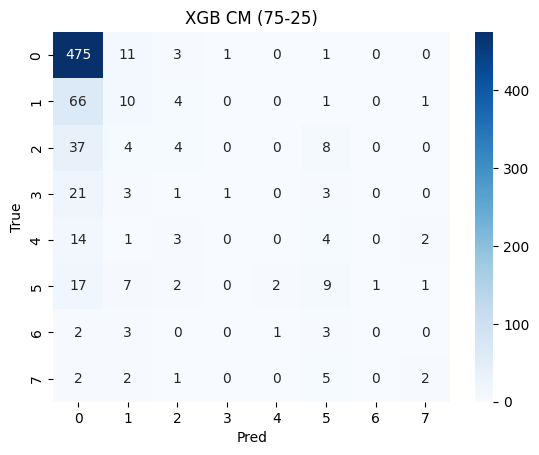


LGBM:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 2215, number of used features: 70
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
acc: 0.6603518267929634
f1: 0.6085695466767029
prec: 0.5754347872870519
rec: 0.6603518267929634
              precision    

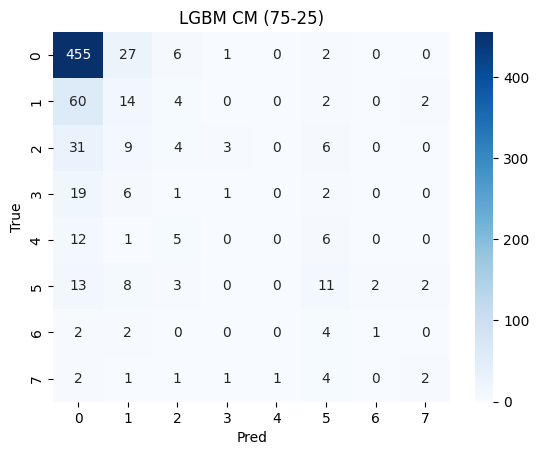


=== Split 70-30 ===

LogReg:


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


acc: 0.46786922209695603
f1: 0.5405892550260165
prec: 0.6645177390372462
rec: 0.46786922209695603
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       589
           1       0.17      0.24      0.20        99
           2       0.07      0.11      0.09        63
           3       0.04      0.09      0.05        35
           4       0.02      0.03      0.02        30
           5       0.20      0.20      0.20        46
           6       0.08      0.27      0.12        11
           7       0.19      0.43      0.26        14

    accuracy                           0.47       887
   macro avg       0.21      0.25      0.21       887
weighted avg       0.66      0.47      0.54       887



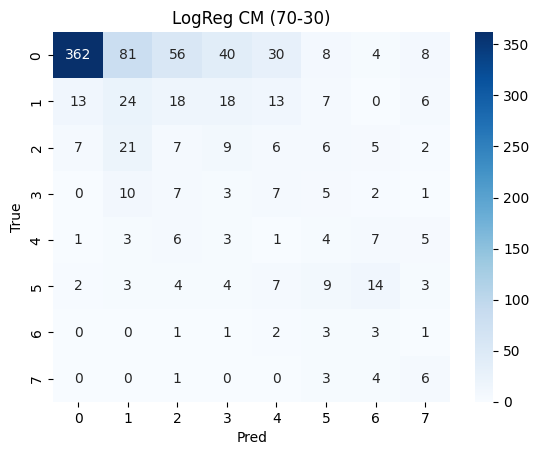


SVM:
acc: 0.4599774520856821
f1: 0.5279485486330388
prec: 0.6704461750243366
rec: 0.4599774520856821
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       589
           1       0.15      0.34      0.21        99
           2       0.13      0.25      0.17        63
           3       0.08      0.14      0.10        35
           4       0.07      0.10      0.09        30
           5       0.22      0.30      0.25        46
           6       0.00      0.00      0.00        11
           7       0.18      0.14      0.16        14

    accuracy                           0.46       887
   macro avg       0.22      0.23      0.21       887
weighted avg       0.67      0.46      0.53       887



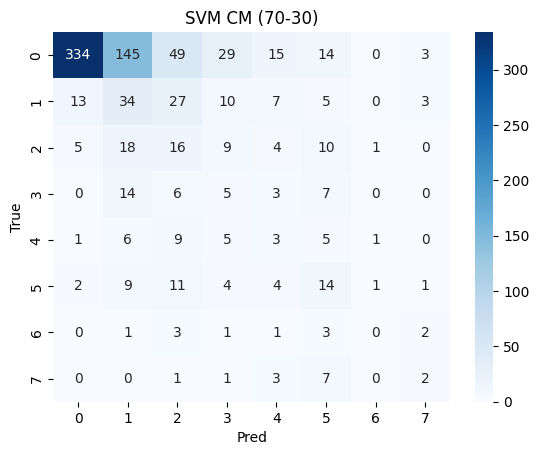


DT:
acc: 0.5298759864712514
f1: 0.5418588571380359
prec: 0.5558400888063358
rec: 0.5298759864712514
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       589
           1       0.17      0.22      0.19        99
           2       0.16      0.17      0.17        63
           3       0.03      0.03      0.03        35
           4       0.03      0.03      0.03        30
           5       0.14      0.15      0.15        46
           6       0.00      0.00      0.00        11
           7       0.17      0.14      0.15        14

    accuracy                           0.53       887
   macro avg       0.18      0.18      0.18       887
weighted avg       0.56      0.53      0.54       887



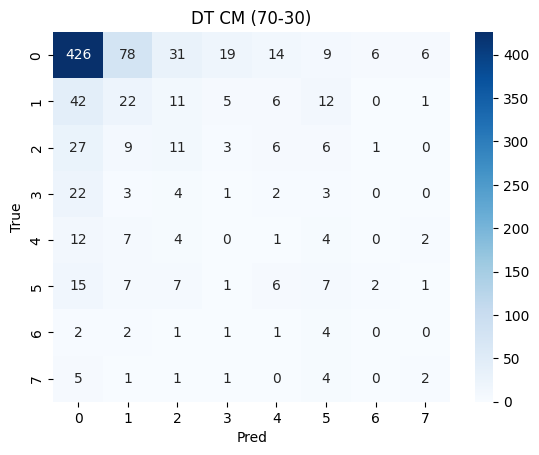


RF:
acc: 0.6696730552423901
f1: 0.5442806126954204
prec: 0.5859426638750201
rec: 0.6696730552423901
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       589
           1       1.00      0.01      0.02        99
           2       0.00      0.00      0.00        63
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00        30
           5       0.38      0.07      0.11        46
           6       0.00      0.00      0.00        11
           7       0.50      0.07      0.12        14

    accuracy                           0.67       887
   macro avg       0.32      0.14      0.13       887
weighted avg       0.59      0.67      0.54       887



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


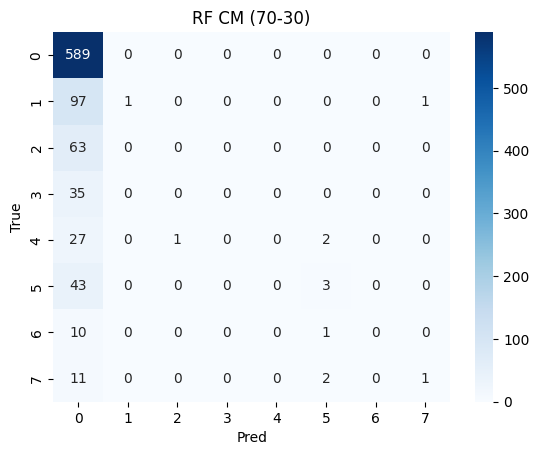


XGB:
acc: 0.6674182638105975
f1: 0.5963765511834105
prec: 0.5625269543319479
rec: 0.6674182638105975
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       589
           1       0.24      0.12      0.16        99
           2       0.19      0.10      0.13        63
           3       0.33      0.03      0.05        35
           4       0.00      0.00      0.00        30
           5       0.22      0.15      0.18        46
           6       0.00      0.00      0.00        11
           7       0.40      0.14      0.21        14

    accuracy                           0.67       887
   macro avg       0.26      0.19      0.20       887
weighted avg       0.56      0.67      0.60       887



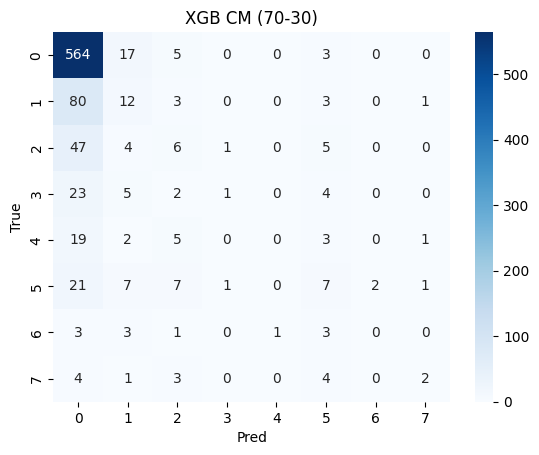


LGBM:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3098
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 70
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
acc: 0.6583990980834273
f1: 0.602609889519782
prec: 0.57580

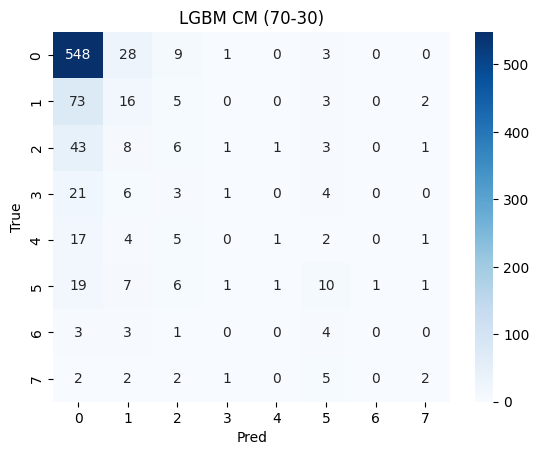

In [10]:
splits = [(0.2,'80-20'), (0.25,'75-25'), (0.3,'70-30')]

for test_size, label in splits:
    print(f"\n=== Split {label} ===")
    X_train, X_test, y_train, y_test = train_test_split(
        data[numeric+categorical], data['y'],
        test_size=test_size, random_state=42, stratify=data['y']
    )
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p  = preprocessor.transform(X_test)

    for name, model in models:
        print(f"\n{name}:")
        model.fit(X_train_p, y_train)
        y_pred = model.predict(X_test_p)
        print("acc:", accuracy_score(y_test, y_pred))
        print("f1:", f1_score(y_test, y_pred, average='weighted'))
        print("prec:", precision_score(y_test, y_pred, average='weighted'))
        print("rec:", recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} CM ({label})"); plt.xlabel("Pred"); plt.ylabel("True")
        plt.show()